In [1]:
require("igraph")

Loading required package: igraph


Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union




In [2]:
n <- 100
p <- 2

In [3]:
y<- matrix(rnorm(n*p),n)

In [4]:
D<- as.matrix(dist(y))

In [5]:
logS <- -(D**2)/2/0.1

In [6]:
findMST<- function(logS){
    G<- graph_from_adjacency_matrix(-logS, mode = "undirected",weighted = TRUE,diag=FALSE)
    G_mst<- mst(graph = G)
    A_T<- as.matrix(get.adjacency(G_mst))
    A_T
}


In [7]:
rgumbel<- function(n){
-log(-log(runif(n)))
}

gumbelMax<- function(logA){
    which.max( logA+ rgumbel(length(logA)))
}

drawT_approx<- function(logS){
    gumbelMat<- matrix(0,n,n)
    gumbelMat[lower.tri(gumbelMat,diag = FALSE)]<- rgumbel((n-1)/2*(n))
    gumbelMat<- gumbelMat+ t(gumbelMat)
    A_T<- findMST(logS+gumbelMat)
    A_T
}

drawT_exact<- function(logS){

    n<- nrow(logS)

    A_T<- matrix(0,n,n)

    InTree<- list()
    Next <- list()

    for (i in 1:(n)){
      InTree[[i]]<- FALSE
    }

    r<- n
    InTree[[r]]<- TRUE
    Next[[r]]<- n

    for (i in (n):1){
      u = i
      while(!InTree[[u]]){
        Next[[u]]<- gumbelMax(logS[u,])
        u <- Next[[u]]
      }
      u = i
      while(!InTree[[u]]){
        InTree[[u]]= TRUE
        u <- Next[[u]]
      }
    }

    for (u in 1:n){
      A_T[u, Next[[u]]]=1
      A_T[Next[[u]],u]=1
    } 
    A_T
}


In [8]:
#slower sampler using Aldous Broder

tree1 = drawT_exact(logS)

In [9]:
#faster sampler using Gumbel-Max tree
tree2 = drawT_approx(logS)

In [10]:
sum(tree1)

[1] 199

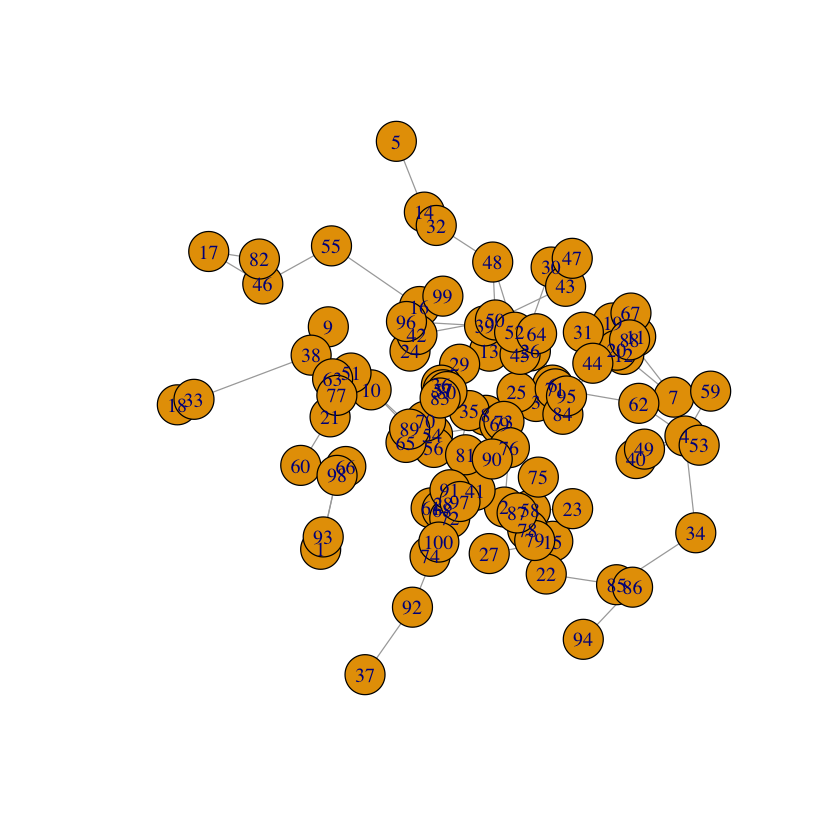

In [11]:
G_tree1<- graph_from_adjacency_matrix(tree1, mode = "undirected",weighted = TRUE,diag=FALSE)
plot(G_tree1,layout=y)

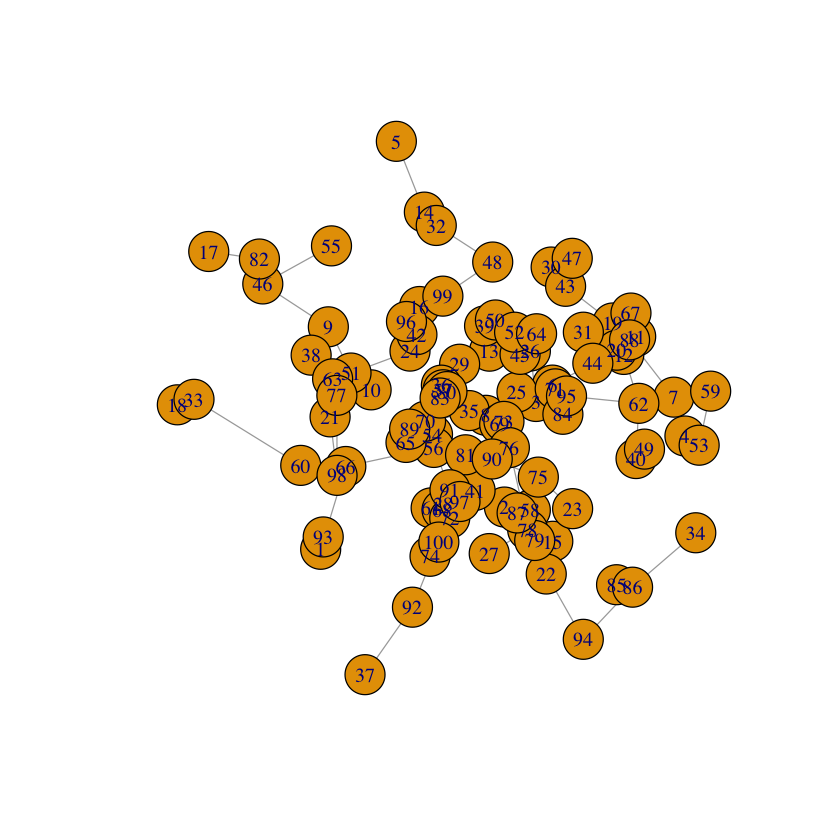

In [12]:
G_tree2<- graph_from_adjacency_matrix(tree2, mode = "undirected",weighted = TRUE,diag=FALSE)
plot(G_tree2,layout=y)

In [13]:
# let's compare the marginal edge inclusion probability (or, marginal connecting probability) matrix


In [14]:
# this matrix has a closed-form
# see https://arxiv.org/abs/2202.00493, proof B.1.

W = exp(logS)

diag(W)<- 0

L <- diag(rowSums(W))-W

L_inv = solve(L+ 1/n/n)

diag_L_inv = diag(L_inv)

M = (outer(diag_L_inv,diag_L_inv,"+")- 2*L_inv)*W

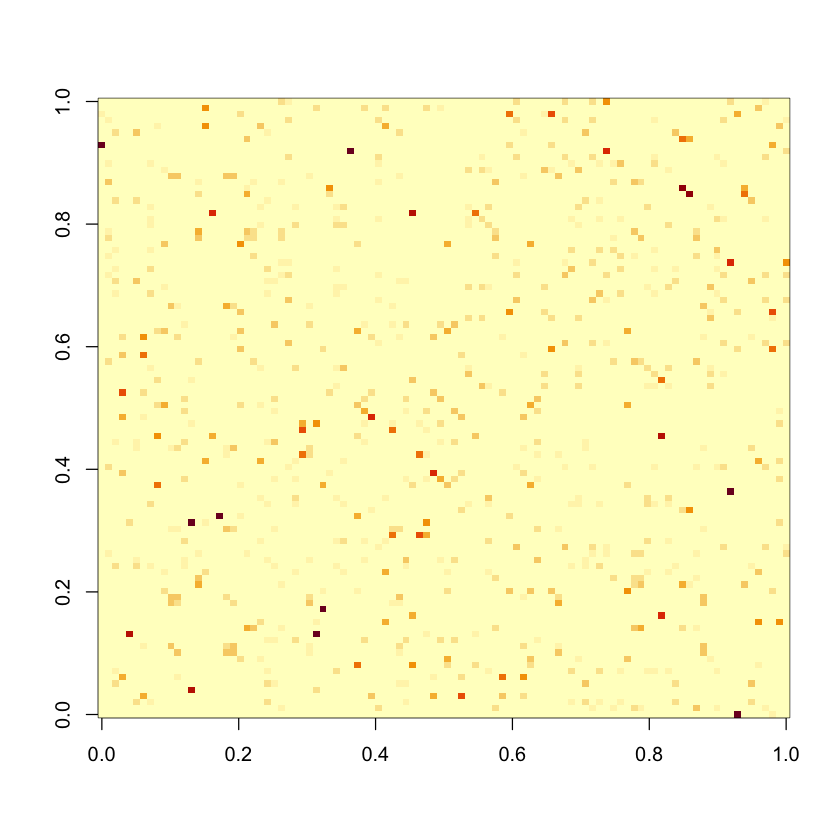

In [15]:
image(M)

In [16]:
# let's use fast approx sampler to draw 1000 trees


accuApproxTrees = 0

In [17]:
for (s in 1:1000){
    tree2 = drawT_approx(logS)
    accuApproxTrees = accuApproxTrees+ tree2
}



In [18]:
# empirical connecting prob using approx sampler

empiricalM = accuApproxTrees/1000

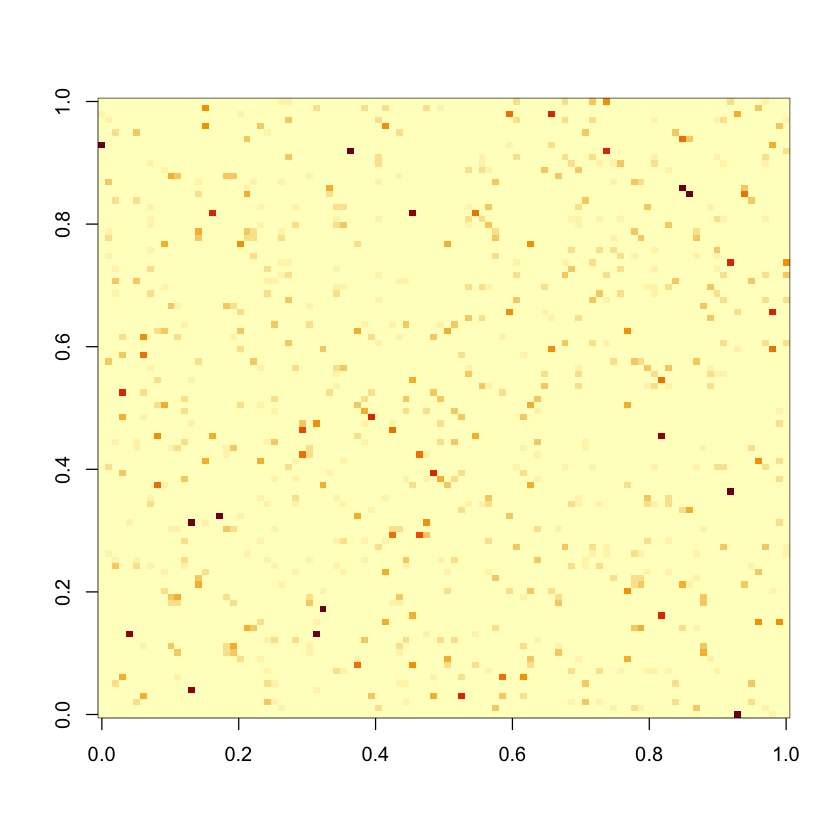

In [19]:
image(empiricalM)

In [20]:
# compare with the true value

In [21]:
LtriIdx = lower.tri(M)

In [22]:
diff = (abs(empiricalM - M))[LtriIdx]

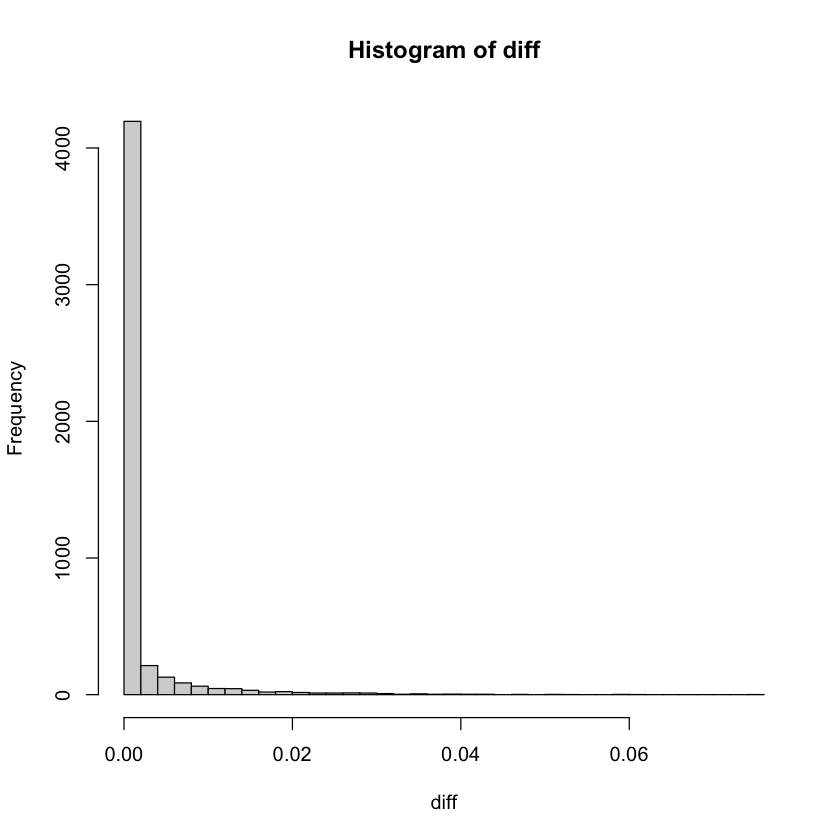

In [23]:
hist(diff,breaks = 50)